# AutoViz

In [ ]:
using AutomotiveDrivingModels
using AutoViz

In [1]:
using AutomotiveDrivingModels
include("../src/AutoViz.jl")
using AutoViz

## Rendering Scenes

You can render a scene by simply providing one along with a roadway.

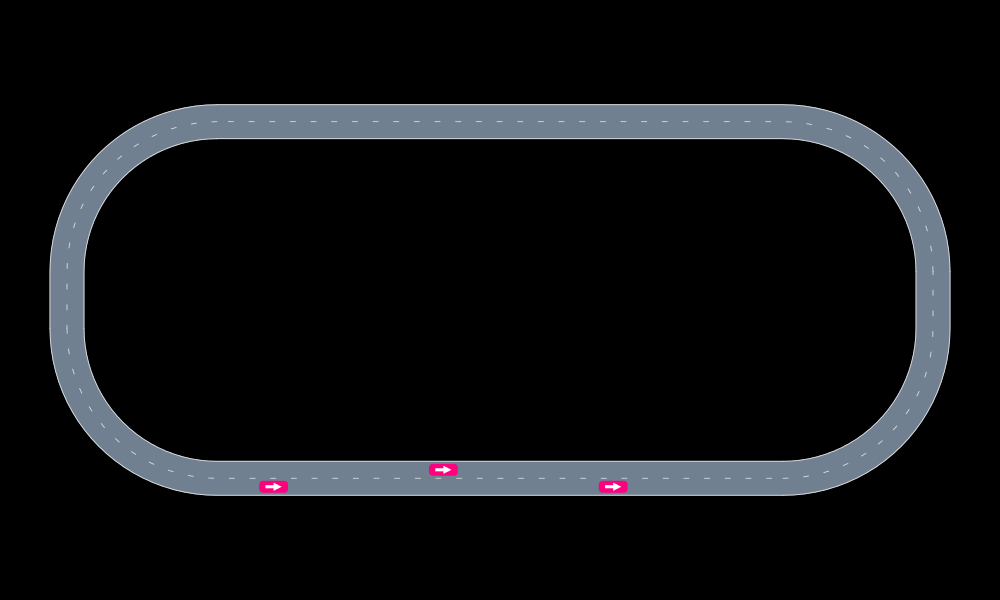

In [2]:
car_len = 4.8
car_width = 1.8

roadway = gen_stadium_roadway(2)
scene = Scene()
push!(scene,Vehicle(VehicleState(VecSE2(10.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 29.0+randn()), 
                    VehicleDef(1, AgentClass.CAR, car_len, car_width)))
push!(scene,Vehicle(VehicleState(VecSE2(40.0,0.0,0.0), roadway, 29.0+randn()), 
                    VehicleDef(2, AgentClass.CAR, car_len, car_width)))
push!(scene,Vehicle(VehicleState(VecSE2(70.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 29.0+randn()), 
                    VehicleDef(3, AgentClass.CAR, car_len, car_width)))

render(scene, roadway, cam=FitToContentCamera())

You can also render roadways by themselves.

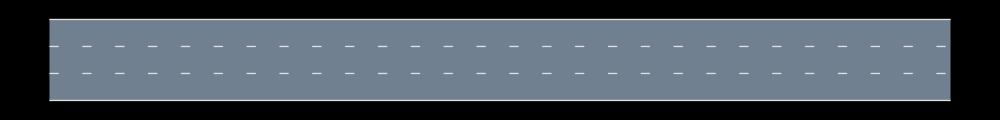

In [3]:
render(gen_straight_roadway(3, 100.0), canvas_height=120)

## Cameras

A number of cameras are supported.

`StaticCamera` has a fixed position

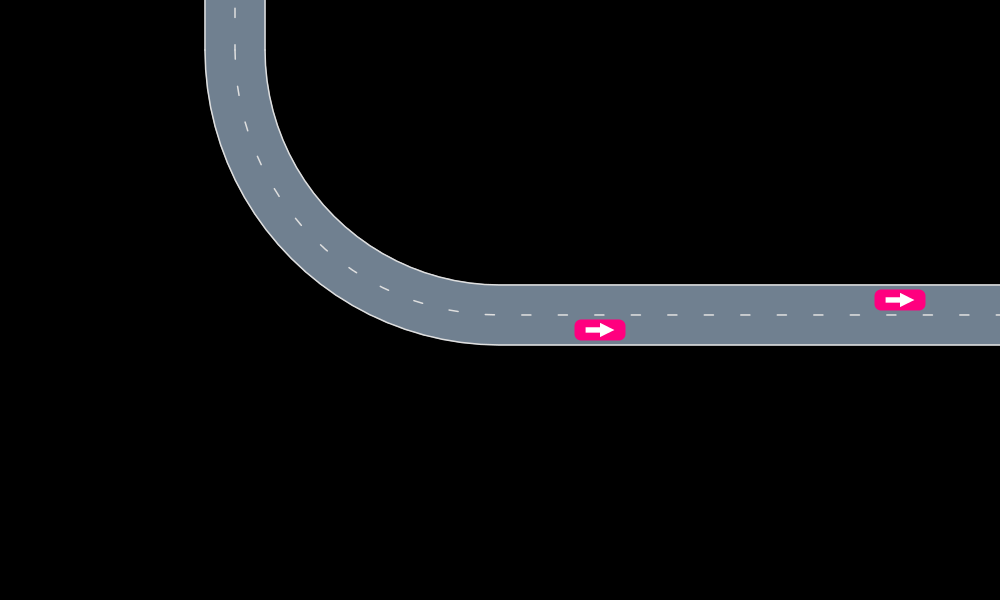

In [4]:
pos = VecE2(0.0,0.0)
zoom = 10.0 # [pix/meter]
render(scene, roadway, cam=StaticCamera(pos, zoom))

`FitToContentCamera` will fit over everything

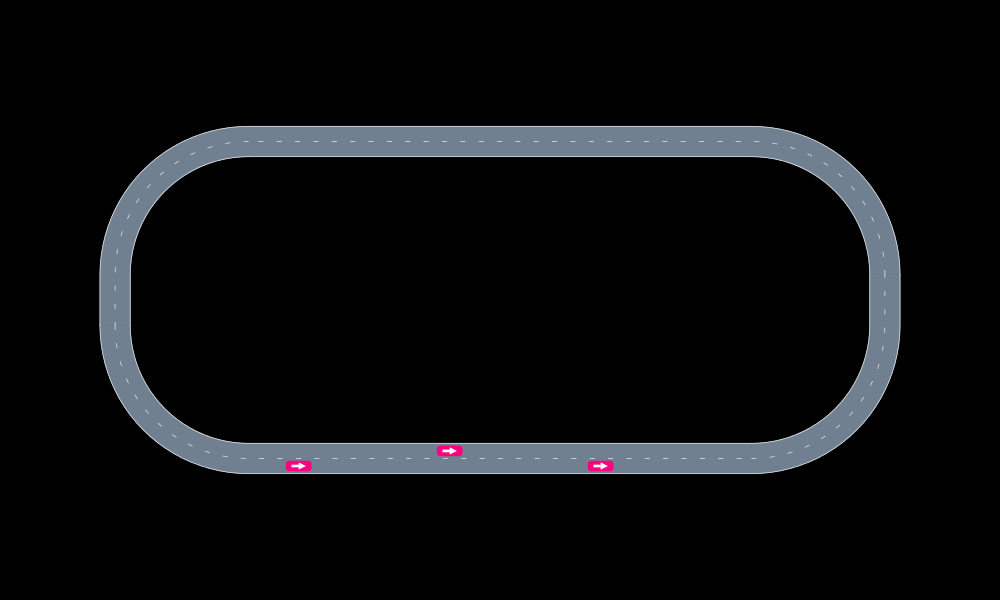

In [5]:
border_fraction = 0.20
render(scene, roadway, cam=FitToContentCamera(border_fraction))

`CarFollowCamera` centers on a particular vehicle

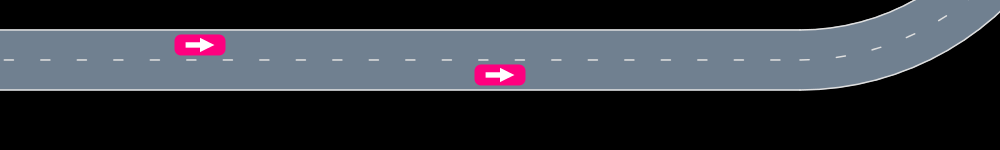

In [6]:
targetid = 3
zoom = 10.0
render(scene, roadway, cam=CarFollowCamera(targetid, zoom), canvas_height=150)

`SceneFollowCamera` centers itself over all vehicles.

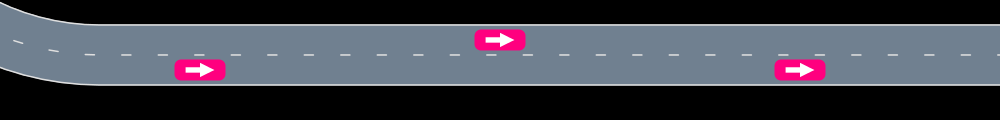

In [7]:
render(scene, roadway, cam=SceneFollowCamera(zoom), canvas_height=120)

## Vehicle Colors

Colors can be assigned to particular ids.

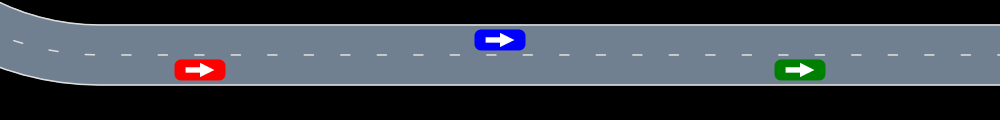

In [8]:
carcolors = Dict{Int,Colorant}()
carcolors[1] = colorant"red"
carcolors[2] = colorant"blue"
carcolors[3] = colorant"green"
render(scene, roadway, cam=SceneFollowCamera(zoom), special_car_colors=carcolors, canvas_height=120)

## Scene Overlays

Overlays provide a means of showing additional information

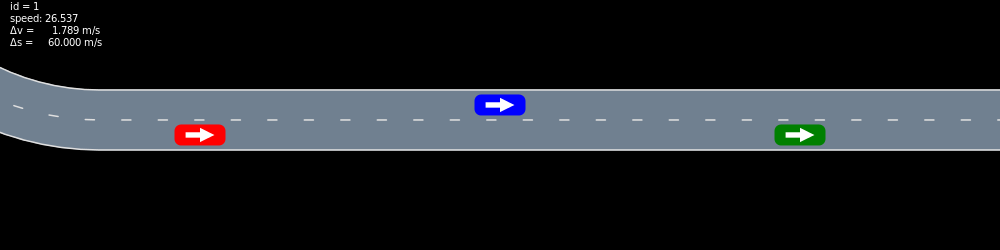

In [9]:
# Here we show the car following stats for vehicle 1 (the red one)
render(scene, roadway, [CarFollowingStatsOverlay(1)], cam=SceneFollowCamera(zoom), canvas_height=250, special_car_colors=carcolors)

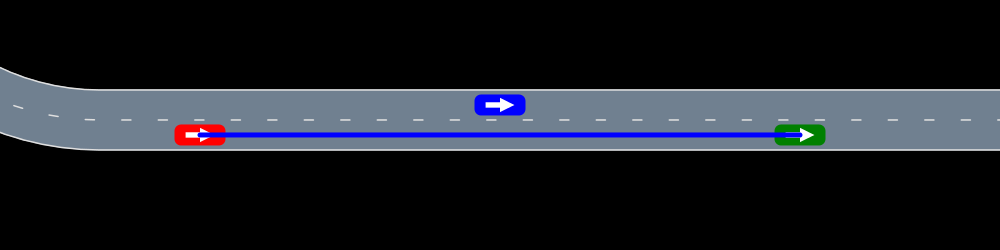

In [10]:
render(scene, roadway, [LineToFrontOverlay(1)], cam=SceneFollowCamera(zoom), canvas_height=250, special_car_colors=carcolors)

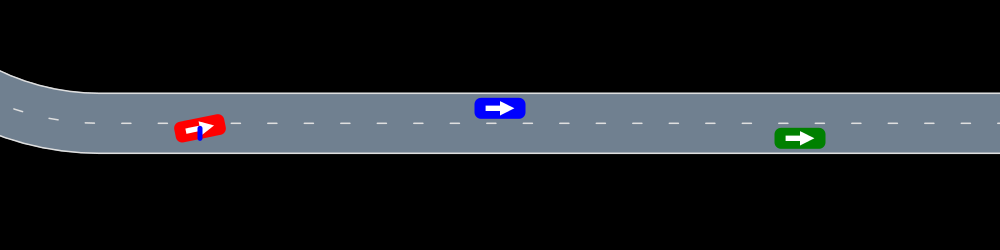

In [12]:
scene[1].state = VehicleState(VecSE2(10.0,-DEFAULT_LANE_WIDTH+1.0,0.2), roadway, 29.0)
render(scene, roadway, [LineToCenterlineOverlay(1)], cam=SceneFollowCamera(zoom), canvas_height=250, special_car_colors=carcolors)

## Simulation

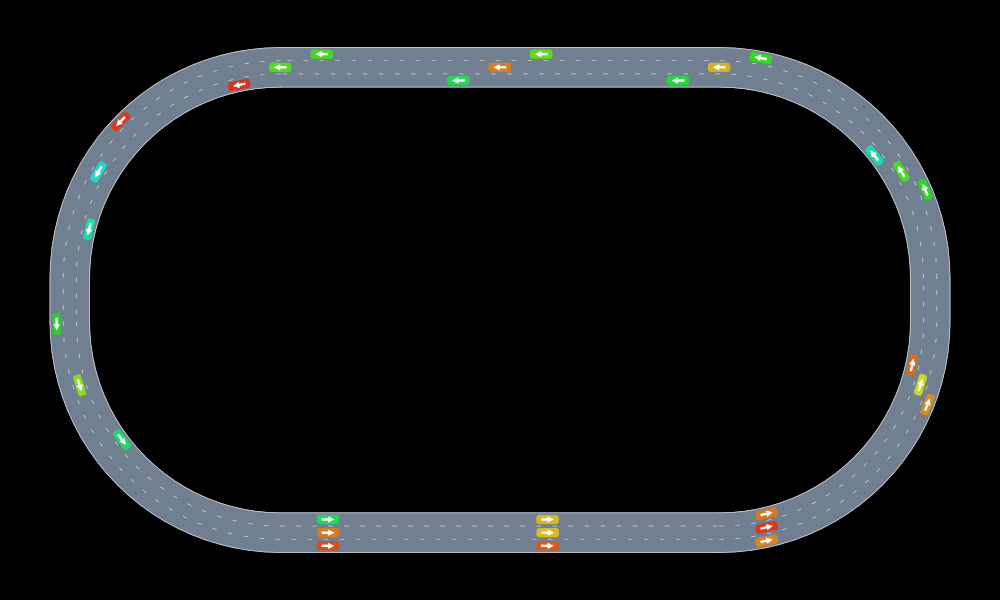

In [13]:
srand(0)
roadway = gen_stadium_roadway(3, radius=45.0)

start_roadinds = [RoadIndex(proj(VecSE2(0.0,-1*DEFAULT_LANE_WIDTH,0.0), roadway)),
                  RoadIndex(proj(VecSE2(0.0,-0*DEFAULT_LANE_WIDTH,0.0), roadway)),
                  RoadIndex(proj(VecSE2(0.0,-2*DEFAULT_LANE_WIDTH,0.0), roadway))]
start_delta_s = 10.0:50.0:480.0
ncars = length(start_roadinds) * length(start_delta_s)

scene = Scene()
framerate = 24
context = IntegratedContinuous(1/framerate,3)
models = Dict{Int, DriverModel}()
carcolors = Dict{Int,Colorant}()
base_speed, x, j, id_count = 20.0, 10, 0, 0
for roadind in start_roadinds
    vehstate = VehicleState(Frenet(roadind, roadway), roadway, base_speed+randn())
    for delta_s in start_delta_s    
        vehstate2 = move_along(vehstate, roadway, delta_s)
        vehdef = VehicleDef(id_count+=1, AgentClass.CAR, 4.826, 1.81)
        push!(scene,Vehicle(vehstate2, vehdef))
    
        models[id_count] = Tim2DDriver(context, rec=SceneRecord(1, context.Δt, ncars))
        set_desired_speed!(models[id_count], 10.0 + 20*rand())
        carcolors[id_count] = convert(RGB, HSV(180*rand(), 0.85, 0.85))
    end
end

actions = get_actions!(Array(DriveAction, length(scene)), scene, roadway, models)

function drawsim(t, dt=NaN)
    get_actions!(actions, scene, roadway, models)
    tick!(scene, roadway, actions, models)
    render(scene, roadway, cam=FitToContentCamera(), special_car_colors=carcolors)
end

drawsim(1)

You can use `Reel` to generate movies.

In [ ]:
using Reel
film = roll(drawsim, fps=framerate, duration=5)
# write("mygif.gif", film) # Write to a gif file

## Watch 'em Drive
You can use Reactive to have them endlessly drive in real time in your browser.

In [ ]:
using Reactive

ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)